In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%shell 
git clone https://github.com/Tandon-A/emotic.git

Cloning into 'emotic'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 333 (delta 67), reused 49 (delta 46), pack-reused 255
Receiving objects: 100% (333/333), 48.56 MiB | 38.49 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [5]:
%cd emotic/

/content/emotic


In [24]:
import torch 
device = torch.device('cpu')
print(device)

cpu


In [21]:
import os 
import numpy as np 

img_list = np.asarray([s for s in os.listdir('/content') if s[0:4]=='test'])
img_list = np.sort(img_list)

array(['test_1.jpeg', 'test_2.jpeg', 'test_3.jpeg', 'test_4.jpeg'],
      dtype='<U11')

#**Creating Bounding Boxes for each image in `img_txt`**

In [29]:
from yolo_utils import prepare_yolo
from yolo_inference import get_bbox
import cv2
import os 

yolo = prepare_yolo('/content')
yolo = yolo.to(device)
yolo.eval()

for img in img_list:
  image_context_path = os.path.join('/content',img)
  image_context = cv2.cvtColor(cv2.imread(image_context_path), cv2.COLOR_BGR2RGB)

  bbox = get_bbox(yolo, device, image_context)[0]
  with open('/content/img_list', 'a') as f:
    f.write(image_context_path + " " + f'{bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}' + '\n')

prepared yolo model


#**Utils**

In [31]:
import cv2
import numpy as np 
import os 

import torch 
from torchvision import transforms

from emotic import Emotic 
import matplotlib.pyplot as plt

def return_Quadrant(Valence_Arousal, thresh):
  v,a = Valence_Arousal
  if v>thresh and a>thresh:
    return 1 
  elif v<thresh and a>thresh:
    return 2 
  elif v<thresh and a<thresh:
    return 3 
  elif v>thresh and a<thresh:
    return 4 

def normalize_negative_one(Val_Arousal):
    normalized_input = (Val_Arousal - 1) / (9 - 1)
    return 2*normalized_input - 1

def process_images(context_norm, body_norm, image_context_path=None, image_context=None, image_body=None, bbox=None):
  ''' Prepare context and body image. 
  :param context_norm: List containing mean and std values for context images. 
  :param body_norm: List containing mean and std values for body images. 
  :param image_context_path: Path of the context image. 
  :param image_context: Numpy array of the context image.
  :param image_body: Numpy array of the body image. 
  :param bbox: List to specify the bounding box to generate the body image. bbox = [x1, y1, x2, y2].
  :return: Transformed image_context tensor and image_body tensor.
  '''
  if image_context is None and image_context_path is None:
    raise ValueError('both image_context and image_context_path cannot be none. Please specify one of the two.')
  if image_body is None and bbox is None: 
    raise ValueError('both body image and bounding box cannot be none. Please specify one of the two')

  if image_context_path is not None:
    image_context =  cv2.cvtColor(cv2.imread(image_context_path), cv2.COLOR_BGR2RGB)
  
  if bbox is not None:
    image_body = image_context[bbox[1]:bbox[3],bbox[0]:bbox[2]].copy()
  
  image_context = cv2.resize(image_context, (224,224))
  image_body = cv2.resize(image_body, (128,128))
  
  test_transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
  context_norm = transforms.Normalize(context_norm[0], context_norm[1])  
  body_norm = transforms.Normalize(body_norm[0], body_norm[1])

  image_context = context_norm(test_transform(image_context)).unsqueeze(0)
  image_body = body_norm(test_transform(image_body)).unsqueeze(0)

  return image_context, image_body  


def infer(context_norm, body_norm, ind2cat, ind2vad, device, thresholds, models, image_context_path=None, image_context=None, image_body=None, bbox=None, to_print=True):
  ''' Perform inference over an image. 
  :param context_norm: List containing mean and std values for context images. 
  :param body_norm: List containing mean and std values for body images. 
  :param ind2cat: Dictionary converting integer index to categorical emotion. 
  :param ind2vad: Dictionary converting integer index to continuous emotion dimension (Valence, Arousal and Dominance).
  :param device: Torch device. Used to send tensors to GPU if available.
  :param image_context_path: Path of the context image. 
  :param image_context: Numpy array of the context image.
  :param image_body: Numpy array of the body image. 
  :param bbox: List to specify the bounding box to generate the body image. bbox = [x1, y1, x2, y2].
  :param to_print: Variable to display inference results.
  :return: Categorical Emotions list and continuous emotion dimensions numpy array.
  '''
  image_context, image_body = process_images(context_norm, body_norm, image_context_path=image_context_path, image_context=image_context, image_body=image_body, bbox=bbox)

  model_context, model_body, emotic_model = models

  with torch.no_grad():
    image_context = image_context.to(device)
    image_body = image_body.to(device)
    
    pred_context = model_context(image_context)
    pred_body = model_body(image_body)
    pred_cat, pred_cont = emotic_model(pred_context, pred_body)
    pred_cat = pred_cat.squeeze(0)
    pred_cont = pred_cont.squeeze(0).to("cpu").data.numpy()

    bool_cat_pred = torch.gt(pred_cat, thresholds)
  
  cat_emotions = list()
  for i in range(len(bool_cat_pred)):
    if bool_cat_pred[i] == True:
      cat_emotions.append(ind2cat[i])

  if to_print == True:
    print ('\n Image predictions')
    print ('Continuous Dimnesions Predictions') 
    for i in range(len(pred_cont)):
      print ('Continuous %10s %.5f' %(ind2vad[i], 10*pred_cont[i]))
    print ('Categorical Emotion Predictions')
    for emotion in cat_emotions:
      print ('Categorical %16s' %(emotion))
  
  return cat_emotions, 10*pred_cont


def inference_emotic(images_list, model_path, result_path, context_norm, body_norm, ind2cat, ind2vad, args):
  ''' Infer on list of images defined in a text file. Save the results in inference_file.txt in the directory specified by the result_path. 
  :param images_list: Text file specifying the images and their bounding box values to conduct inference. A row in the file is Path_of_image x1 y1 x2 y2. 
  :param model_path: Directory path to load models and val_thresholds to perform inference.
  :param result_path: Directory path to save the results (text file containig categorical emotion and continuous emotion dimension prediction per image).
  :param context_norm: List containing mean and std values for context images. 
  :param body_norm: List containing mean and std values for body images. 
  :param ind2cat: Dictionary converting integer index to categorical emotion. 
  :param ind2vad: Dictionary converting integer index to continuous emotion dimension (Valence, Arousal and Dominance).
  :param args: Runtime arguments.
  '''
  with open(images_list, 'r') as f:
    lines = f.readlines()
  
  device = torch.device("cuda:%s" %(str(0)) if torch.cuda.is_available() else "cpu")
  thresholds = torch.FloatTensor(np.load(os.path.join(result_path, 'val_thresholds.npy'))).to(device) 
  model_context = torch.load(os.path.join(model_path,'model_context1.pth')).to(device)
  model_body = torch.load(os.path.join(model_path,'model_body1.pth')).to(device)
  emotic_model = torch.load(os.path.join(model_path,'model_emotic1.pth')).to(device)
  model_context.eval()
  model_body.eval()
  emotic_model.eval()
  models = [model_context, model_body, emotic_model]


  result_file = os.path.join('/content', 'inference_list.txt')
  with open(result_file, 'w') as f:
    pass
  
  for idx, line in enumerate(lines):
    image_context_path, x1, y1, x2, y2 = line.split('\n')[0].split(' ')

    plt.imshow(plt.imread(image_context_path))
    plt.show()

    bbox = [int(x1), int(y1), int(x2), int(y2)]
    pred_cat, pred_cont = infer(context_norm, body_norm, ind2cat, ind2vad, device, thresholds, models, image_context_path=image_context_path, bbox=bbox)
    
    write_line = list()
    write_line.append(image_context_path)
    for emotion in pred_cat:
      write_line.append(emotion)
    for continuous in pred_cont:
      write_line.append(str('%.4f' %(continuous)))
    write_line = ' '.join(write_line) 
    with open(result_file, 'a') as f:
      f.writelines(write_line)
      f.writelines('\n')


In [32]:
context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]

In [33]:
# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

vad = ['Valence', 'Arousal', 'Dominance']
ind2vad = {}
for idx, continuous in enumerate(vad):
  ind2vad[idx] = continuous

## **Inference**

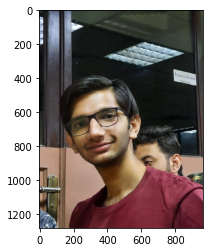


 Image predictions
Continuous Dimnesions Predictions
Continuous    Valence 5.79862
Continuous    Arousal 5.11349
Continuous  Dominance 6.39215
Categorical Emotion Predictions
Categorical     Disquietment
Categorical  Doubt/Confusion
Categorical       Engagement
Categorical        Happiness


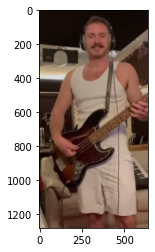


 Image predictions
Continuous Dimnesions Predictions
Continuous    Valence 5.70708
Continuous    Arousal 6.58083
Continuous  Dominance 6.86640
Categorical Emotion Predictions
Categorical     Anticipation
Categorical       Confidence
Categorical     Disquietment
Categorical  Doubt/Confusion
Categorical           Esteem
Categorical       Excitement


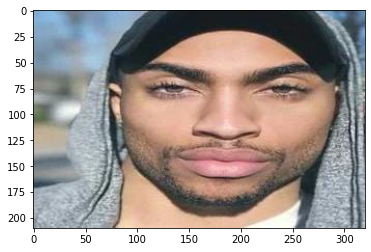


 Image predictions
Continuous Dimnesions Predictions
Continuous    Valence 4.74451
Continuous    Arousal 4.87736
Continuous  Dominance 5.17166
Categorical Emotion Predictions
Categorical        Affection
Categorical            Anger
Categorical        Annoyance
Categorical         Aversion
Categorical      Disapproval
Categorical     Disquietment
Categorical  Doubt/Confusion
Categorical          Fatigue
Categorical             Fear
Categorical        Happiness
Categorical             Pain
Categorical         Pleasure
Categorical          Sadness
Categorical      Sensitivity
Categorical        Suffering
Categorical         Surprise


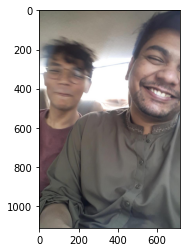


 Image predictions
Continuous Dimnesions Predictions
Continuous    Valence 5.59163
Continuous    Arousal 4.96415
Continuous  Dominance 5.67625
Categorical Emotion Predictions
Categorical        Affection
Categorical        Annoyance
Categorical      Disapproval
Categorical     Disquietment
Categorical  Doubt/Confusion
Categorical             Fear
Categorical        Happiness
Categorical         Pleasure
Categorical         Surprise


In [34]:

# inference_emotic(images_list ='/content/img_list',model_path='/content/drive/MyDrive/model', result_path='/content/img_list',ind2cat,args = 'inference')
args = 0
images_list ='/content/img_list'
model_path='/content/drive/MyDrive/model'
result_path='/content/drive/MyDrive/model/results'
inference_emotic(images_list, model_path, result_path, context_norm, body_norm, ind2cat, ind2vad, args)

#**Generating Quadrants for the specified Valence Arousal score**


1.   **Q1 (High Valence, High Arousal)**
2.   **Q2 (Low Valence, High Arousal)**
3.   **Q3 (Low Valence, Low Arousal)**
4.   **Q4 (High Valence, Low Arousal)**



In [35]:
with open('/content/inference_list.txt', 'r') as f:
  lines = f.readlines()
  for line in lines:
    va = line.split(' ')[-3:-1]


In [37]:
import numpy as np

VA_scores = list()
with open('/content/inference_list.txt', 'r') as f:
  inferences = f.readlines()
  for inference in inferences:
    VA_scores.append(inference.split(' ')[-3:-1])


VA_scores = np.asarray(VA_scores,dtype=np.float32)

In [60]:
emotion_tags = list()
for i, score in enumerate(VA_scores):
  emotion_tags.append(return_Quadrant(normalize_negative_one(score),0))
  

##**Generated Emotion Tags**

In [58]:
emotion_tags

[1, 1, 3, 4]